<a href="https://colab.research.google.com/github/rapidwindow/Light-economic/blob/main/custom_LeNet_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, InputLayer, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import RMSprop
!pip install -q -U keras-tuner
import keras_tuner as kt

In [2]:
# MNISTデータを読込む
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# MNISTデータを加工する
img_rows, img_cols = 28, 28
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
# リストの後ろからN個の要素を削除
x_train = x_train[:-58000]
y_train = y_train[:-58000]
x_train  = x_train.astype('float32')
x_test   = x_test.astype('float32')
x_train /= 255
x_test  /= 255
y_train  = keras.utils.to_categorical(y_train, 10)
y_test   = keras.utils.to_categorical(y_test, 10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
#モデルを定義する
def build_model(hp):
  model = Sequential()
  model.add(InputLayer(input_shape=(img_rows, img_cols, 1)))
  #畳み込み層(1)
  model.add(Conv2D(filters=6, kernel_size=(5, 5), activation='relu'))
  #プーリング層(1)
  model.add(MaxPooling2D(pool_size=(2, 2)))
  #畳み込み層(2)
  model.add(Conv2D(filters=16, kernel_size=(5, 5), activation='relu'))
  #プーリング層(2)
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  hp_units = hp.Int('units', min_value=0, max_value=512, step=32)
  model.add(Dense(units=hp_units, activation="relu"))
  if hp.Choice('batchnorm_and_dropout', ['batch', 'dropout', 'both']) == 'batch':
    model.add(layers.BatchNormalization())
  elif hp.Choice('batchnorm_and_dropout', ['batch', 'dropout', 'both']) == 'dropout':
    model.add(layers.Dropout(0.2))
  else:
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
  activation1=hp.Choice("activation1", ["relu", "tanh"])
  model.add(Dense(units=120, activation=activation1))
  activation2=hp.Choice("activation2", ["relu", "tanh"])
  model.add(Dense(units=84, activation=activation2))
  model.add(Dense(units=10, activation = 'softmax'))
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-3, sampling="log")
  model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
  return model

In [4]:
#ハイパーパラメータ探索を行うTunerを作成
tuner = kt.Hyperband(
    hypermodel=build_model,
    objective='val_accuracy',
    max_epochs=60,
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [5]:
#実際に探索する
tuner.search(x_train, y_train,
             validation_data=(x_test, y_test),
             callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5)], epochs=60)

Trial 90 Complete [00h 02m 49s]
val_accuracy: 0.9498999714851379

Best val_accuracy So Far: 0.9653000235557556
Total elapsed time: 00h 58m 59s


In [22]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
score = best_model.evaluate(x_test, y_test, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9602 - loss: 0.1411
Test loss: 0.11985058337450027
Test accuracy: 0.9653000235557556


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


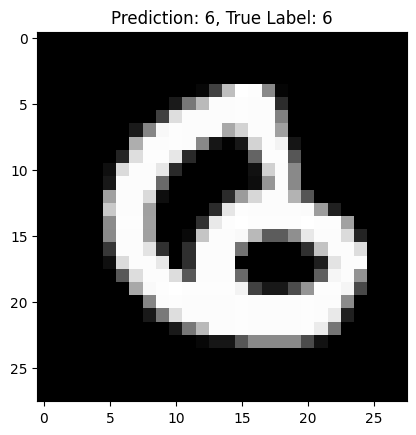

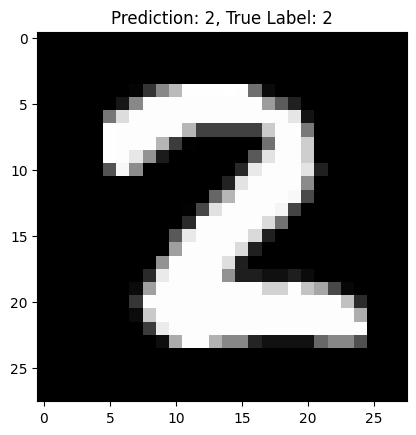

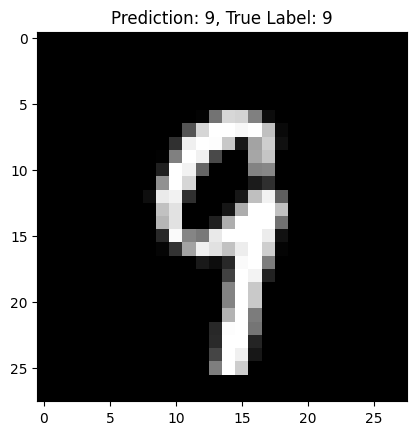

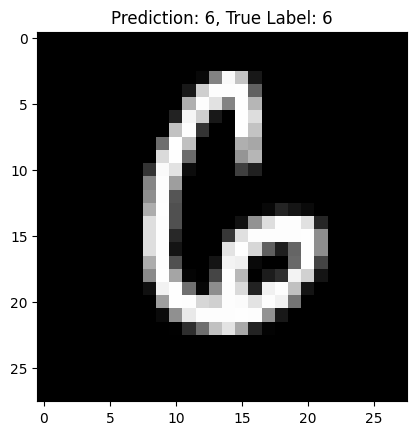

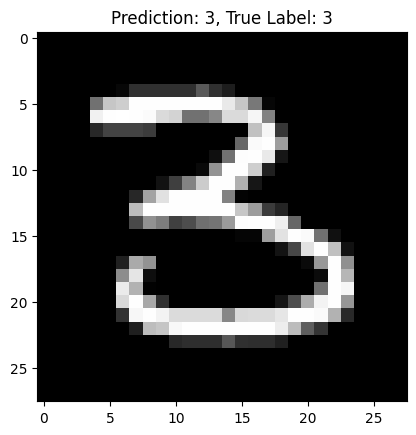

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# x_test: テストデータ
# y_test: 正解ラベル

# テストデータに対する予測を取得
predictions = best_model.predict(x_test)

# いくつかの画像をランダムに選択
num_images_to_show = 5
random_indices = np.random.choice(len(x_test), size=num_images_to_show, replace=False)

# 画像と予測結果を表示
for i in random_indices:
    # 画像の表示
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title(f'Prediction: {np.argmax(predictions[i])}, True Label: {np.argmax(y_test[i])}')
    plt.show()